In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import PIL
import tensorflow as tf
import os
import shutil
import pandas as pd
import pathlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


Data link: https://www.kaggle.com/datasets/maysee/mushrooms-classification-common-genuss-images

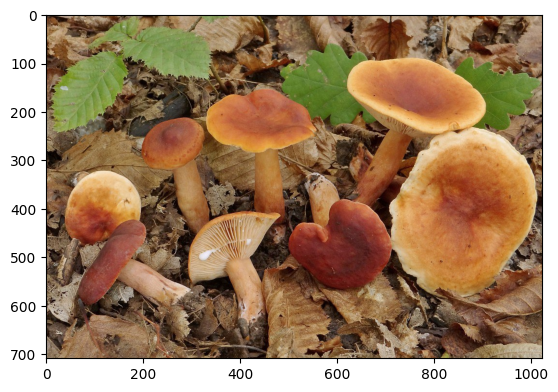

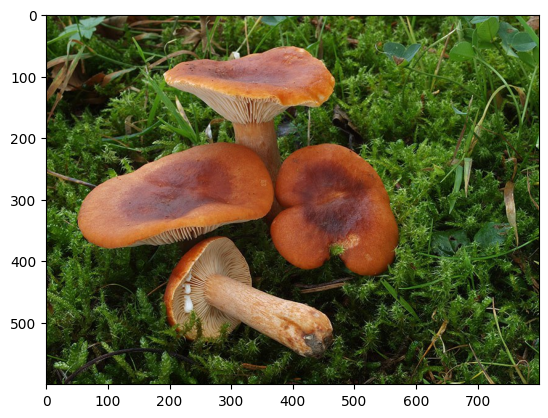

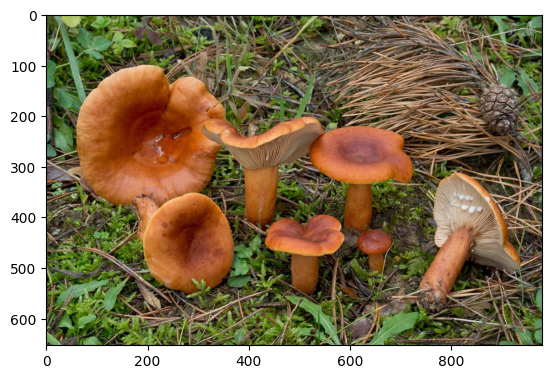

In [2]:
# Directory Path Setup
data = pathlib.Path("G:/Ph.D. course/S1/CSC 7343 Deep Learning Systems/Assignment/Mushrooms-20231205T034004Z-001/Mushrooms")
lactarius_path = data / 'Lactarius'

for file_path in list(lactarius_path.glob('*.*'))[:3]:
    img = mpimg.imread(str(file_path))
    plt.imshow(img)
    plt.show()

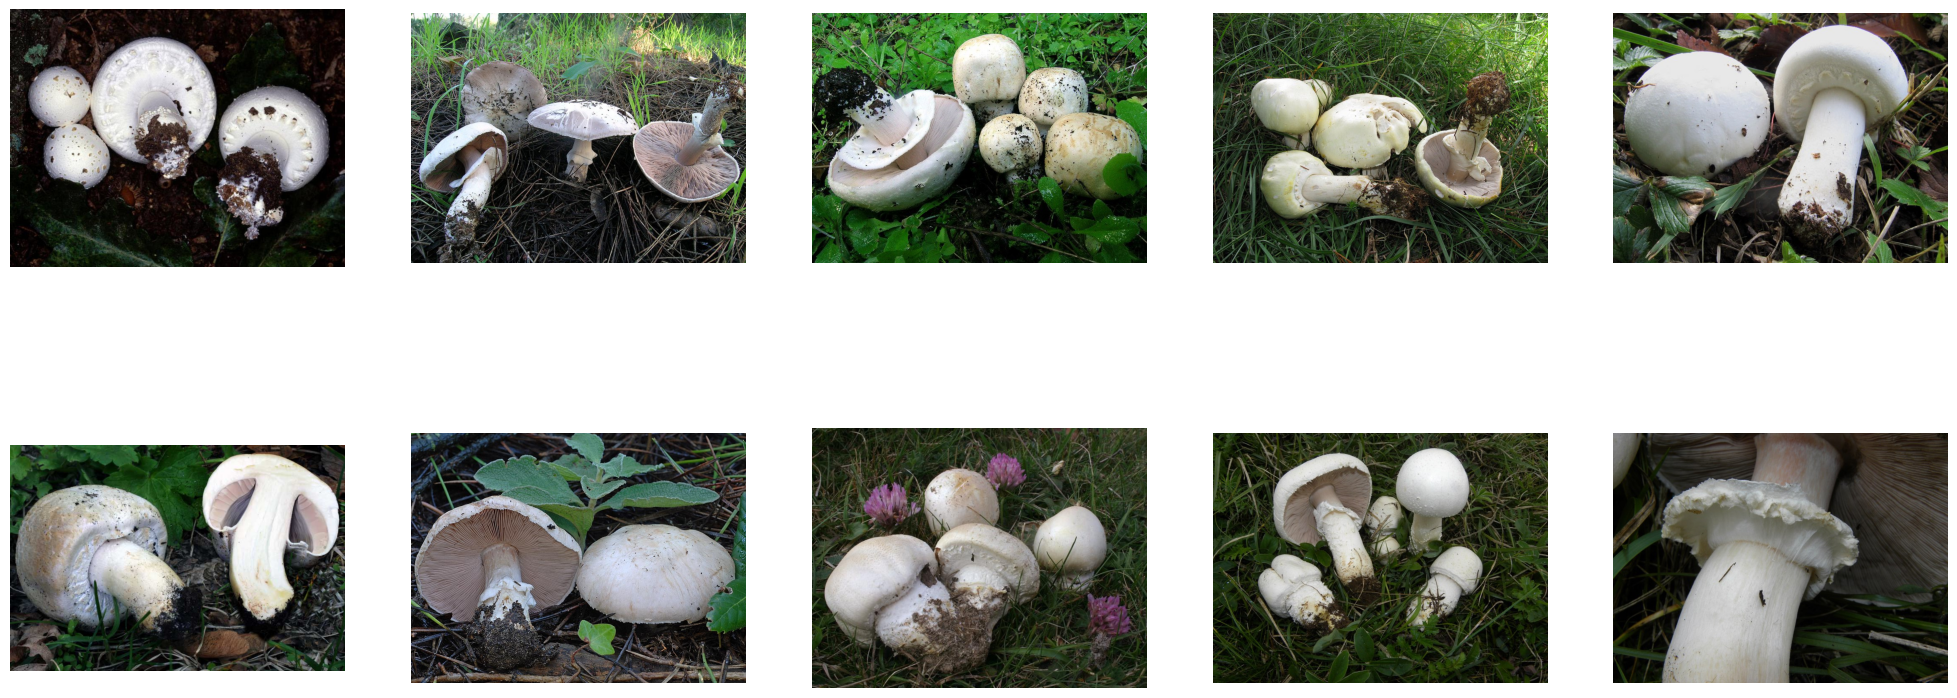

In [3]:
# Display 10 images from Mushroom
jpgfiles = data.glob('*/*.jpg')
plt.figure(figsize=(25, 10))
for i, jpg in zip(range(10), jpgfiles):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(PIL.Image.open(str(jpg)))
    plt.axis("off")

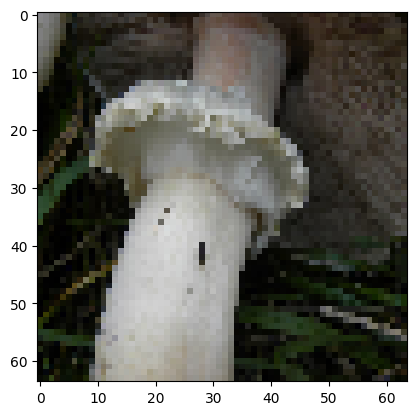

In [4]:
# Resize an image and then display it
resize_layer = tf.keras.layers.Resizing(
    height = 64,
    width = 64,
    interpolation='bilinear'
)

img = np.array(PIL.Image.open(str(jpg)))
resized_img = resize_layer(img)

plt.imshow(resized_img.numpy().astype(int))

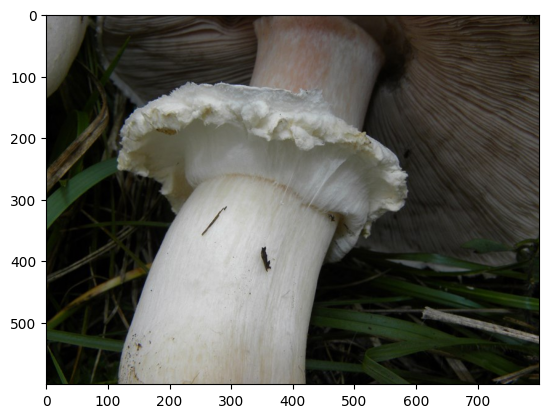

In [5]:
# Display the resized image's original look
plt.imshow(img)

In [6]:
# Create image datasets for training and validation
batch_size = 64
img_height = 64
img_width = 64

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  data,
  validation_split=0.1,
  subset="both",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6402 files belonging to 8 classes.
Using 5762 files for training.
Using 640 files for validation.


In [7]:
# Unpacks the batch into two variables and display shapes of these two tensors
x, y = next(iter(train_ds))
x.shape, y.shape

(TensorShape([64, 64, 64, 3]), TensorShape([64]))

In [8]:
# Printing class_names
# Verify that the dataset has correctly inferred all the classes and their order
class_names = train_ds.class_names
print(class_names)

['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula']


In [9]:
# Initialize a dictionary to count the number of cases per class
class_counts = {class_name: 0 for class_name in class_names}

# Count the number of cases per class in the training set
for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[class_names[label]] += 1

# Print the results
for class_name in class_names:
    print(f"{class_name}: {class_counts[class_name]}")

Agaricus: 322
Amanita: 683
Boletus: 969
Cortinarius: 744
Entoloma: 322
Hygrocybe: 283
Lactarius: 1403
Russula: 1036


In [10]:
# Define the data augmentation settings
datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest')

# Create a new dataset using data augmentation
augmented_ds = datagen.flow_from_directory(
    data,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed=123,
    shuffle=True,
    class_mode='categorical')

Found 6402 images belonging to 8 classes.


In [11]:
#Standrtize the dataset
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

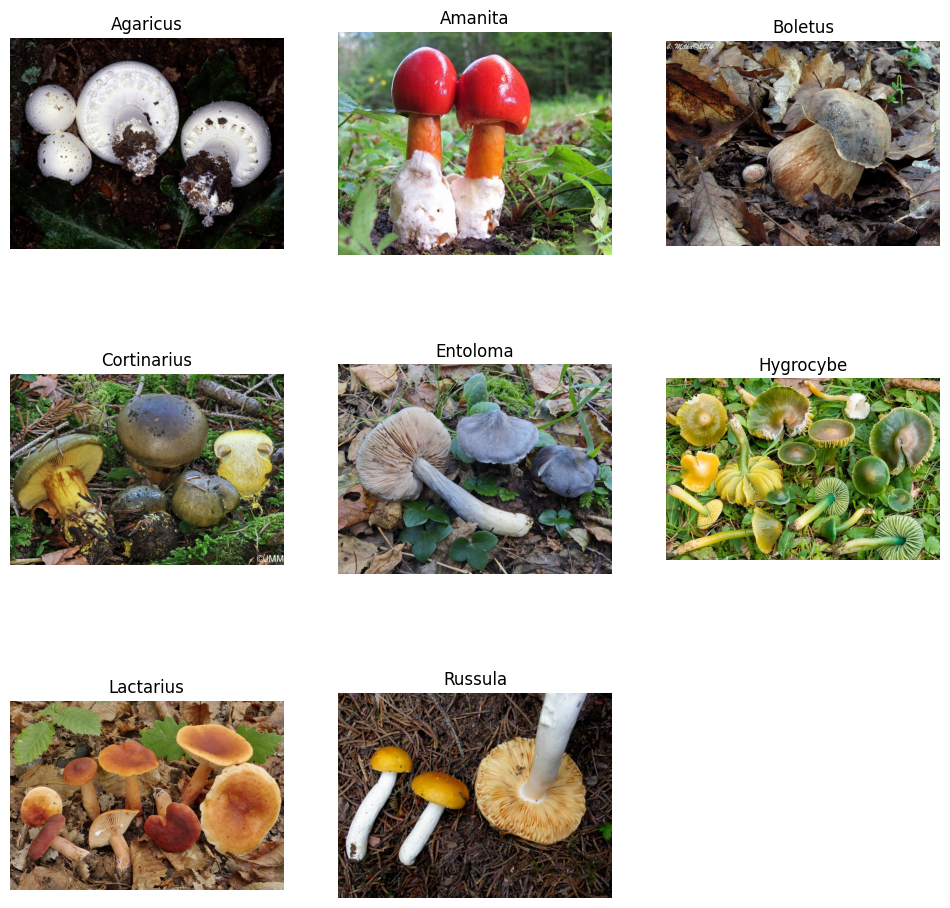

In [12]:
# Display images from 8 subfolders within Mushroom
nrows = 3
ncols = 3
pos = 0
import matplotlib.image as mpimg
for subfolder in os.listdir(data):

    image_file = os.listdir(os.path.join(data, subfolder))[0]

    fig = plt.gcf()
    fig.set_size_inches(ncols * 4, nrows * 4)

    pos += 1
    sp = plt.subplot(nrows, ncols, pos)

    cur_image = mpimg.imread(os.path.join(data, subfolder, image_file))
    plt.imshow(cur_image)
    plt.title(subfolder)
    plt.axis('Off')

In [13]:
#  Inspect the shape of image and label batches in dataset
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 64, 64, 3)
(64,)


In [14]:
#  Creates data augmentation pipeline
data_augmentation = tf.keras.models.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
  ]
)

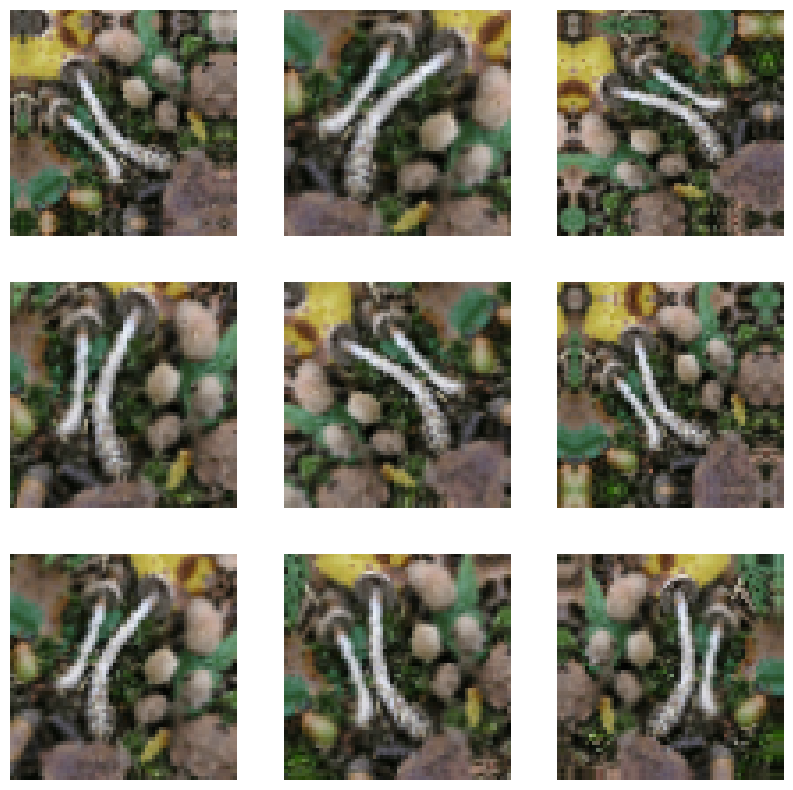

In [15]:
# Visualizes the effects of data augmentation pipeline on images from (train_ds)
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [16]:
# Optimizes the loading of training and validation datasets for more efficient training of a deep learning model. 
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
tf.data.AUTOTUNE

-1

In [18]:
# Normalizing image data 
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [19]:
# Defines layers of a convolutional neural network (CNN)
input_layer = tf.keras.layers.InputLayer(input_shape=(img_height,img_width,3))
conv1_8_3x3 = tf.keras.layers.Conv2D(filters=8, kernel_size=3, strides=1, padding='valid', activation='relu')
maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
conv2_8_2x2 = tf.keras.layers.Conv2D(filters=16, kernel_size=2, strides=1, padding='valid', activation='relu')
maxpool2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
flatten = tf.keras.layers.Flatten()

In [20]:
model = tf.keras.models.Sequential(
    [
        data_augmentation,
        input_layer,
        conv1_8_3x3,
        maxpool1,
        conv2_8_2x2,
        maxpool2,
        flatten,
        tf.keras.layers.Dense(3600/2, activation='relu'),
        tf.keras.layers.Dense(8, activation='softmax')
    ]
)
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 16)        528       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 16)       0         
 2D)                                                  

In [21]:
# training
epochs=150
batch = 80
Table = pd.DataFrame()
history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=batch,
    epochs=epochs,
    verbose = 0
)

D:\Pythonanaconda\envs\tf\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


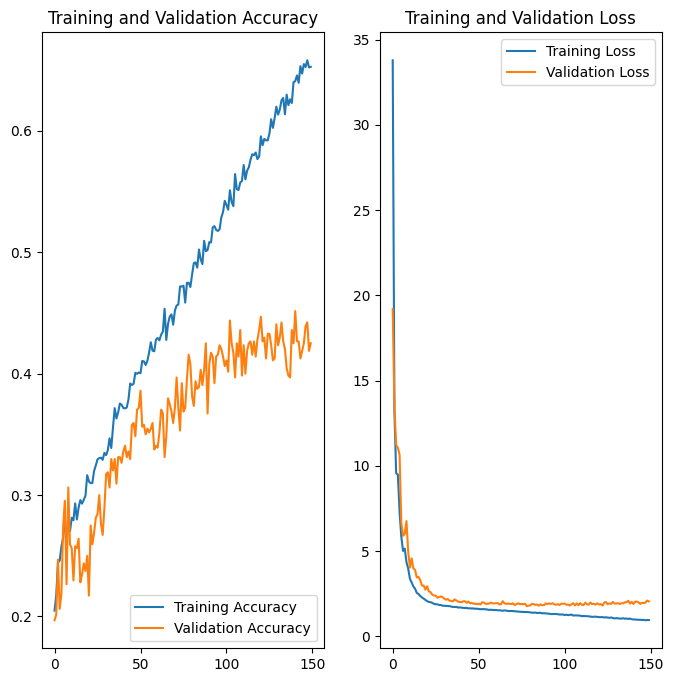

In [22]:
# Visualizing the training and validation accuracy and loss over epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
# model_f8_w3x3
# Trying different parameters' combinations
# Two convolutional layers (conv1 and conv2) for feature extraction, with varying filter sizes and numbers. 
# The first uses 8 filters of size 3x3, and the second uses 8 filters of size 2x2.
# Two max pooling layers (maxpool1 and maxpool2) following each convolutional layer to reduce spatial dimensions.
# Flattens the output for the dense layers.

channels1 = 8
kernel1 = 3
epochs=150

input_layer = tf.keras.layers.InputLayer(input_shape=(img_height,img_width,3))
conv1 = tf.keras.layers.Conv2D(filters=channels1, kernel_size=kernel1, strides=1, padding='valid', activation='relu')
maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
conv2 = tf.keras.layers.Conv2D(filters=8, kernel_size=2, strides=1, padding='valid', activation='relu')
maxpool2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
flatten = tf.keras.layers.Flatten()

model = tf.keras.Sequential(
    [
        data_augmentation,
        input_layer,
        conv1,
        maxpool1,
        conv2,
        maxpool2,
        flatten,
        tf.keras.layers.Dense(1800/2, activation='relu'),
        tf.keras.layers.Dense(8, activation='softmax')
    ]
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 input_2 (InputLayer)        multiple                  0         
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 8)         224       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 8)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 30, 8)         264       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 8)        0         
 2D)                                                  

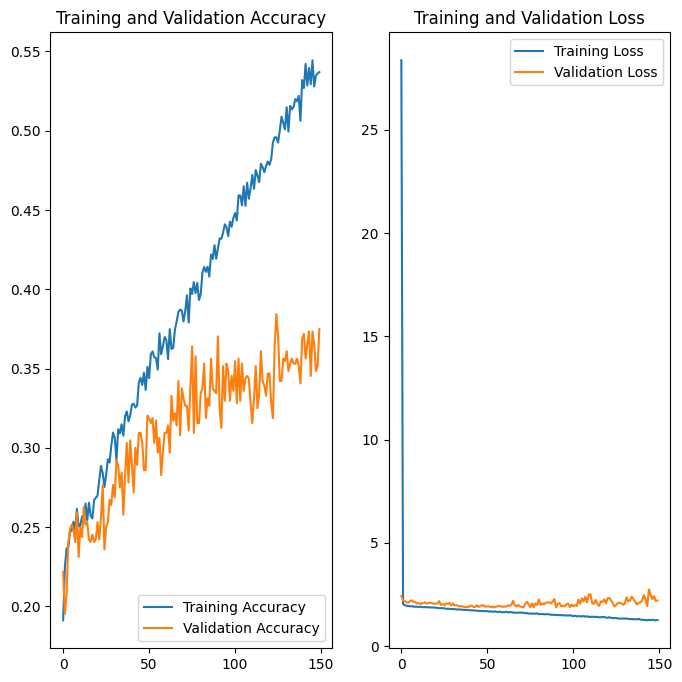

10/10 [==============================] - 0s 12ms/step - loss: 2.2083 - accuracy: 0.3750


List_channel  List_kernel    Acc  epochs
0             8            3  0.375     150

In [24]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=batch,
    epochs=epochs,
    verbose = 0
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

accuracy = model.evaluate(val_ds)[1]

List_epochs = list()
List_epochs.append(epochs)
List_channel = list()
List_channel.append(channels1)
List_kernel = list()
List_kernel.append(kernel1)
Acc = list()
Acc.append(accuracy)

List_epochs = list()
List_epochs.append(epochs)
Table = pd.DataFrame({'List_channel' : List_channel,'List_kernel' : List_kernel,'Acc' : Acc,'epochs':List_epochs,},
                     columns=['List_channel','List_kernel','Acc', 'epochs'])
Table

In [25]:
#model_f8_w5x5
# A convolutional layer with 8 filters of size 5x5
channels1 = 8
kernel1 = 5

input_layer = tf.keras.layers.InputLayer(input_shape=(img_height,img_width,3))
conv1 = tf.keras.layers.Conv2D(filters=channels1, kernel_size=kernel1, strides=1, padding='valid', activation='relu')
maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
conv2 = tf.keras.layers.Conv2D(filters=8, kernel_size=2, strides=1, padding='valid', activation='relu')
maxpool2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
flatten = tf.keras.layers.Flatten()

model = tf.keras.Sequential(
    [
        data_augmentation,
        input_layer,
        conv1,
        maxpool1,
        conv2,
        maxpool2,
        flatten,
        tf.keras.layers.Dense(1568/2, activation='relu'),
        tf.keras.layers.Dense(8, activation='softmax')
    ]
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 input_3 (InputLayer)        multiple                  0         
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 60, 8)         608       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 8)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 8)         264       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 8)        0         
 2D)                                                  

D:\Pythonanaconda\envs\tf\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


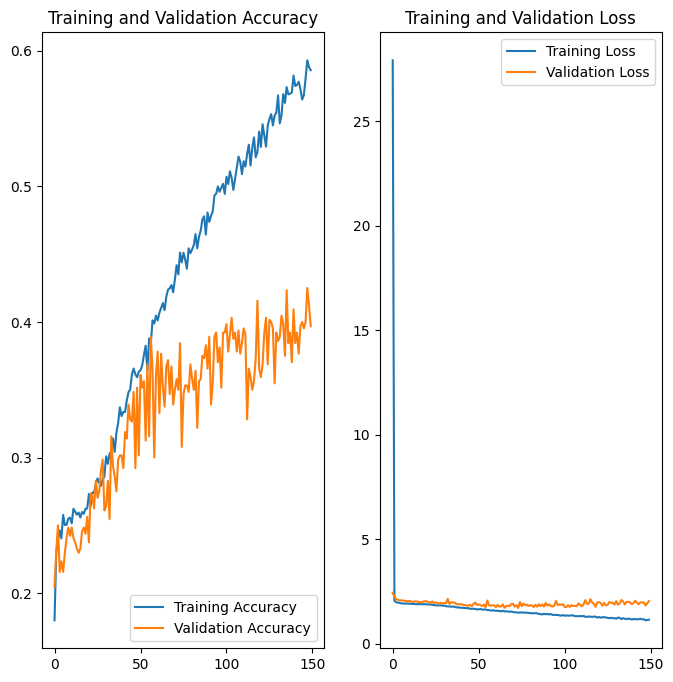

10/10 [==============================] - 0s 15ms/step - loss: 2.0351 - accuracy: 0.3969


List_channel  List_kernel       Acc  epochs
0             8            3  0.375000     150
1             8            5  0.396875     150

In [26]:
epochs=150
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose = 0
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

accuracy = model.evaluate(val_ds)[1]

List_channel.append(channels1)

List_kernel.append(kernel1)

Acc.append(accuracy)

List_epochs.append(epochs)

Table = pd.DataFrame({'List_channel' : List_channel,'List_kernel' : List_kernel,'Acc' : Acc,'epochs':List_epochs},
                     columns=['List_channel','List_kernel','Acc', 'epochs'])
Table

In [27]:
#model_f16_w3x3
channels1 = 16
kernel1 = 3

input_layer = tf.keras.layers.InputLayer(input_shape=(img_height,img_width,3))
conv1 = tf.keras.layers.Conv2D(filters=channels1, kernel_size=kernel1, strides=1, padding='valid', activation='relu')
maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
conv2 = tf.keras.layers.Conv2D(filters=8, kernel_size=2, strides=1, padding='valid', activation='relu')
maxpool2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
flatten = tf.keras.layers.Flatten()
# Get flattened layer dimension

model = tf.keras.Sequential(
    [
        data_augmentation,
        input_layer,
        conv1,
        maxpool1,
        conv2,
        maxpool2,
        flatten,
        tf.keras.layers.Dense(1800/2, activation='relu'),
        tf.keras.layers.Dense(8, activation='softmax')
    ]
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 input_4 (InputLayer)        multiple                  0         
                                                                 
 conv2d_6 (Conv2D)           (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 31, 31, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 30, 30, 8)         520       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 15, 15, 8)        0         
 2D)                                                  

D:\Pythonanaconda\envs\tf\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


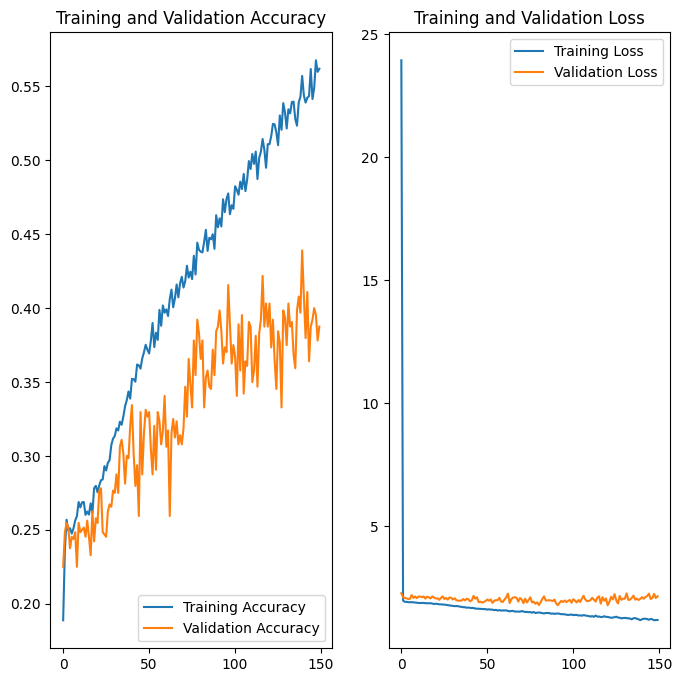

10/10 [==============================] - 0s 15ms/step - loss: 2.1646 - accuracy: 0.3875


List_channel  List_kernel       Acc  epochs
0             8            3  0.375000     150
1             8            5  0.396875     150
2            16            3  0.387500     150

In [28]:
epochs=150
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose = 0
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

accuracy = model.evaluate(val_ds)[1]

List_channel.append(channels1)

List_kernel.append(kernel1)

Acc.append(accuracy)

List_epochs.append(epochs)

Table = pd.DataFrame({'List_channel' : List_channel,'List_kernel' : List_kernel,'Acc' : Acc,'epochs':List_epochs},
                     columns=['List_channel','List_kernel','Acc', 'epochs'])
Table

In [29]:
#model_f16_w5x5
channels1 = 16
kernel1 = 5

input_layer = tf.keras.layers.InputLayer(input_shape=(img_height,img_width,3))
conv1 = tf.keras.layers.Conv2D(filters=channels1, kernel_size=kernel1, strides=1, padding='valid', activation='relu')
maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
conv2 = tf.keras.layers.Conv2D(filters=8, kernel_size=2, strides=1, padding='valid', activation='relu')
maxpool2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
flatten = tf.keras.layers.Flatten()
# Get flattened layer dimension

model = tf.keras.Sequential(
    [
        data_augmentation,
        input_layer,
        conv1,
        maxpool1,
        conv2,
        maxpool2,
        flatten,
        tf.keras.layers.Dense(1568/2, activation='relu'),
        tf.keras.layers.Dense(8, activation='softmax')
    ]
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 input_5 (InputLayer)        multiple                  0         
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 16)        1216      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 29, 29, 8)         520       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 8)        0         
 2D)                                                  

D:\Pythonanaconda\envs\tf\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


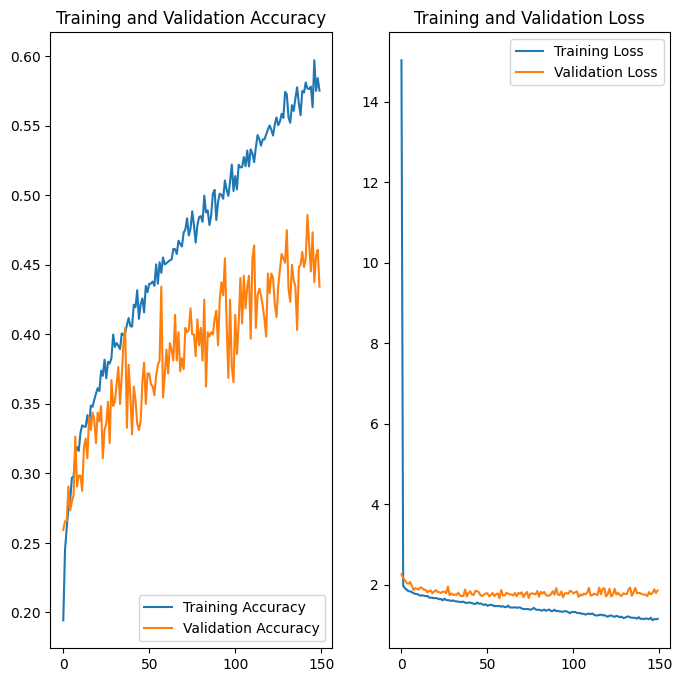

10/10 [==============================] - 0s 18ms/step - loss: 1.8621 - accuracy: 0.4344


List_channel  List_kernel       Acc  epochs
0             8            3  0.375000     150
1             8            5  0.396875     150
2            16            3  0.387500     150
3            16            5  0.434375     150

In [30]:
epochs=150
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose = 0
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

accuracy = model.evaluate(val_ds)[1]

List_channel.append(channels1)

List_kernel.append(kernel1)

Acc.append(accuracy)

List_epochs.append(epochs)

Table = pd.DataFrame({'List_channel' : List_channel,'List_kernel' : List_kernel,'Acc' : Acc,'epochs':List_epochs},
                     columns=['List_channel','List_kernel','Acc', 'epochs'])
Table

In [31]:
#model_f24_w3x3
channels1 = 24
kernel1 = 3

input_layer = tf.keras.layers.InputLayer(input_shape=(img_height,img_width,3))
conv1 = tf.keras.layers.Conv2D(filters=channels1, kernel_size=kernel1, strides=1, padding='valid', activation='relu')
maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
conv2 = tf.keras.layers.Conv2D(filters=8, kernel_size=2, strides=1, padding='valid', activation='relu')
maxpool2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
flatten = tf.keras.layers.Flatten()
# Get flattened layer dimension

model = tf.keras.Sequential(
    [
        data_augmentation,
        input_layer,
        conv1,
        maxpool1,
        conv2,
        maxpool2,
        flatten,
        tf.keras.layers.Dense(1800/2, activation='relu'),
        tf.keras.layers.Dense(8, activation='softmax')
    ]
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 input_6 (InputLayer)        multiple                  0         
                                                                 
 conv2d_10 (Conv2D)          (None, 62, 62, 24)        672       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 31, 31, 24)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 30, 30, 8)         776       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 15, 15, 8)        0         
 g2D)                                                 

D:\Pythonanaconda\envs\tf\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


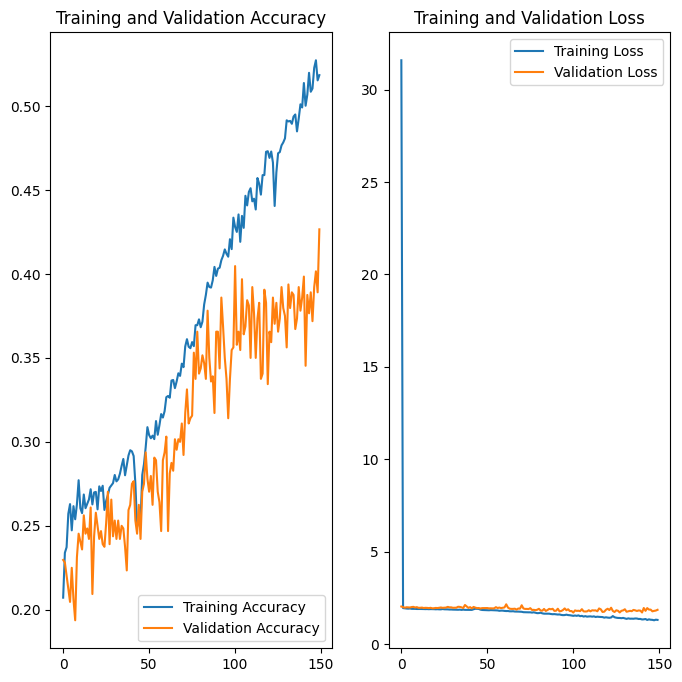

10/10 [==============================] - 0s 18ms/step - loss: 1.8547 - accuracy: 0.4266


List_channel  List_kernel       Acc  epochs
0             8            3  0.375000     150
1             8            5  0.396875     150
2            16            3  0.387500     150
3            16            5  0.434375     150
4            24            3  0.426562     150

In [32]:
epochs=150
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose = 0
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

accuracy = model.evaluate(val_ds)[1]

List_channel.append(channels1)

List_kernel.append(kernel1)

Acc.append(accuracy)

List_epochs.append(epochs)

Table = pd.DataFrame({'List_channel' : List_channel,'List_kernel' : List_kernel,'Acc' : Acc,'epochs':List_epochs},
                     columns=['List_channel','List_kernel','Acc', 'epochs'])
Table

In [33]:
#model_f24_w5x5
channels1 = 24
kernel1 = 5

input_layer = tf.keras.layers.InputLayer(input_shape=(img_height,img_width,3))
conv1 = tf.keras.layers.Conv2D(filters=channels1, kernel_size=kernel1, strides=1, padding='valid', activation='relu')
maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
conv2 = tf.keras.layers.Conv2D(filters=8, kernel_size=2, strides=1, padding='valid', activation='relu')
maxpool2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
flatten = tf.keras.layers.Flatten()
# Get flattened layer dimension

model = tf.keras.Sequential(
    [
        data_augmentation,
        input_layer,
        conv1,
        maxpool1,
        conv2,
        maxpool2,
        flatten,
        tf.keras.layers.Dense(1568/2, activation='relu'),
        tf.keras.layers.Dense(8, activation='softmax')
    ]
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 input_7 (InputLayer)        multiple                  0         
                                                                 
 conv2d_12 (Conv2D)          (None, 60, 60, 24)        1824      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 30, 30, 24)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 29, 29, 8)         776       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 14, 14, 8)        0         
 g2D)                                                 

D:\Pythonanaconda\envs\tf\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


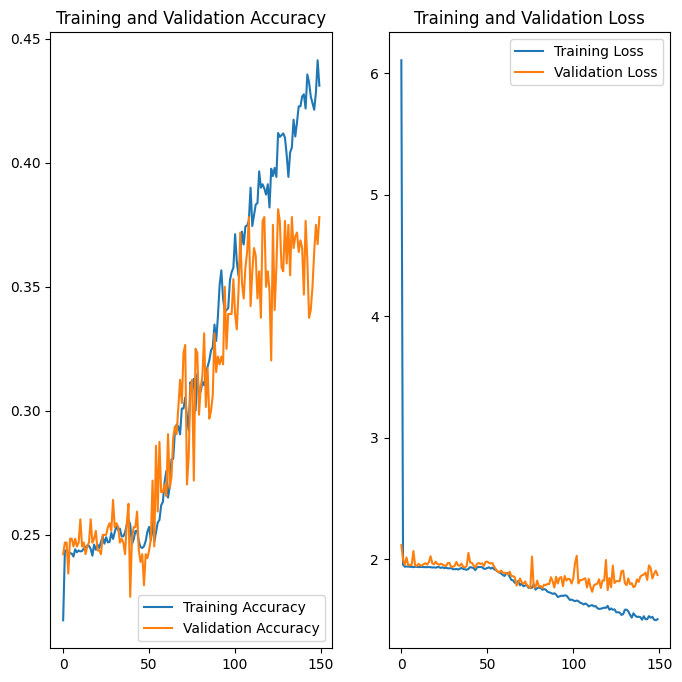

10/10 [==============================] - 0s 20ms/step - loss: 1.8719 - accuracy: 0.3781


List_channel  List_kernel       Acc  epochs
0             8            3  0.375000     150
1             8            5  0.396875     150
2            16            3  0.387500     150
3            16            5  0.434375     150
4            24            3  0.426562     150
5            24            5  0.378125     150

In [34]:
epochs=150
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose = 0
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

accuracy = model.evaluate(val_ds)[1]

List_channel.append(channels1)

List_kernel.append(kernel1)

Acc.append(accuracy)

List_epochs.append(epochs)

Table = pd.DataFrame({'List_channel' : List_channel,'List_kernel' : List_kernel,'Acc' : Acc,'epochs':List_epochs},
                     columns=['List_channel','List_kernel','Acc', 'epochs'])
Table

# Best performance analysis
## We get best Accuracy when channel = 16, kernel = 5

In [35]:
#model_f16_w5x5
channels1 = 16
kernel1 = 5

input_layer = tf.keras.layers.InputLayer(input_shape=(img_height,img_width,3))
conv1 = tf.keras.layers.Conv2D(filters=channels1, kernel_size=kernel1, strides=1, padding='valid', activation='relu')
maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
conv2 = tf.keras.layers.Conv2D(filters=8, kernel_size=2, strides=1, padding='valid', activation='relu')
maxpool2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
flatten = tf.keras.layers.Flatten()
# Get flattened layer dimension

best_model = tf.keras.Sequential(
    [
        data_augmentation,
        input_layer,
        conv1,
        maxpool1,
        conv2,
        maxpool2,
        flatten,
        tf.keras.layers.Dense(1800/2, activation='relu'),
        tf.keras.layers.Dense(8, activation='softmax')
    ]
)
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

best_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 input_8 (InputLayer)        multiple                  0         
                                                                 
 conv2d_14 (Conv2D)          (None, 60, 60, 16)        1216      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 30, 30, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 29, 29, 8)         520       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 14, 14, 8)        0         
 g2D)                                                 

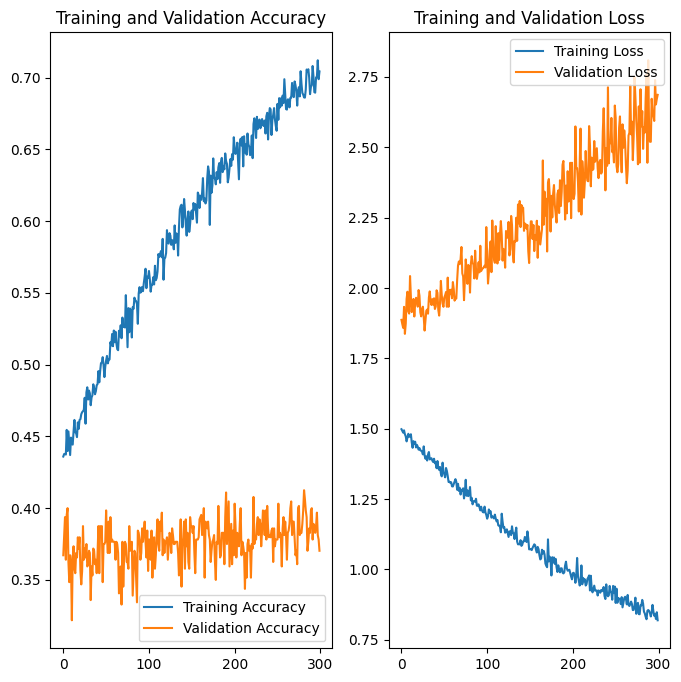

10/10 [==============================] - 0s 20ms/step - loss: 2.6862 - accuracy: 0.3703


List_channel  List_kernel       Acc  epochs
0             8            3  0.375000     150
1             8            5  0.396875     150
2            16            3  0.387500     150
3            16            5  0.434375     150
4            24            3  0.426562     150
5            24            5  0.378125     150
6            16            5  0.370313     300

In [36]:
# Using epochs = 300 to see if we can get better result

epochs=300
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose = 0
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

accuracy = model.evaluate(val_ds)[1]

List_channel.append(channels1)

List_kernel.append(kernel1)

Acc.append(accuracy)

List_epochs.append(epochs)

Best_Table = pd.DataFrame({'List_channel' : List_channel,'List_kernel' : List_kernel,'Acc' : Acc,'epochs':List_epochs},
                          columns=['List_channel','List_kernel','Acc', 'epochs'])
Best_Table

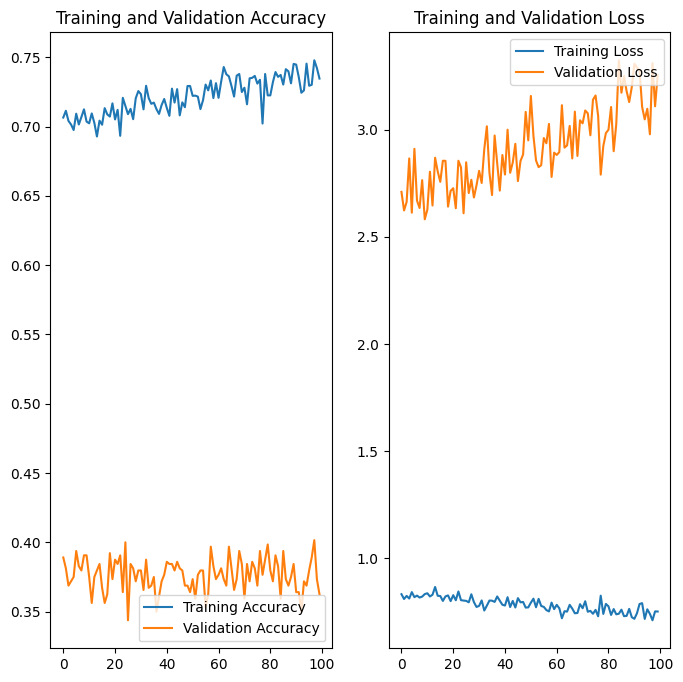

10/10 [==============================] - 0s 21ms/step - loss: 3.2549 - accuracy: 0.3625


List_channel  List_kernel       Acc  epochs
0             8            3  0.375000     150
1             8            5  0.396875     150
2            16            3  0.387500     150
3            16            5  0.434375     150
4            24            3  0.426562     150
5            24            5  0.378125     150
6            16            5  0.370313     300
7            16            5  0.362500     100

In [37]:
epochs=100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose = 0
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

accuracy = model.evaluate(val_ds)[1]

List_channel.append(channels1)

List_kernel.append(kernel1)

Acc.append(accuracy)

List_epochs.append(epochs)

Best_Table = pd.DataFrame({'List_channel' : List_channel,'List_kernel' : List_kernel,'Acc' : Acc,'epochs':List_epochs},
                          columns=['List_channel','List_kernel','Acc', 'epochs'])
Best_Table

D:\Pythonanaconda\envs\tf\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


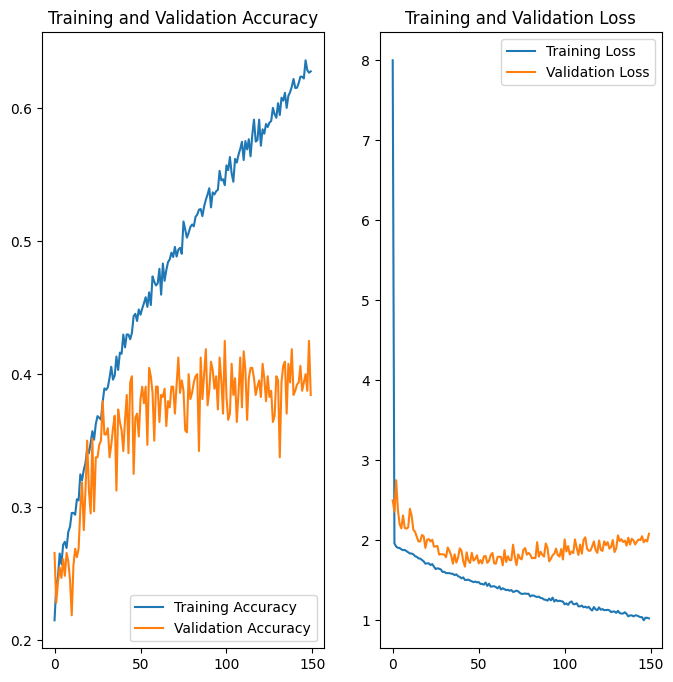

10/10 [==============================] - 0s 19ms/step
Confusion matrix (as percentages per class):
[[19.35  9.68  3.23 16.13  3.23  3.23 12.9  32.26]
 [10.45 28.36  8.96  4.48  7.46  1.49 16.42 22.39]
 [ 0.96  4.81 52.88  5.77  4.81  3.85 18.27  8.65]
 [ 1.09 10.87  3.26 27.17  4.35  9.78 23.91 19.57]
 [ 7.14 14.29  2.38  7.14 28.57  2.38 21.43 16.67]
 [ 0.    9.09  3.03 24.24  6.06 21.21 33.33  3.03]
 [ 6.25  4.38  7.5   9.38  5.62  3.12 43.75 20.  ]
 [ 4.5   9.91  1.8  11.71  6.31  3.6  27.93 34.23]]


In [38]:
# 150 epochs we can get better performance
"""
Display result as confusion matrix
Each row of the matrix represents the instances of an actual class, while each column represents the instances of a predicted class. 
The values are presented as percentages, indicating the proportion of predictions for each class. 
For example, the first row shows that 16.13% of the actual class 1 instances were correctly predicted as class 1, 
while 9.68% of them were incorrectly predicted as class 2, and so on for other classes.


"""

epochs=150
history = best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose = 0
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

from sklearn.metrics import confusion_matrix

# Get the true labels and predictions for the test set
test_labels = np.concatenate([y for x, y in val_ds], axis=0)
y_pred = model.predict(val_ds, verbose=1)
pred_labels = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, pred_labels)

# Normalize the confusion matrix per class
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Print the confusion matrix as percentages per class
print("Confusion matrix (as percentages per class):")
print(np.round(cm_norm * 100, decimals=2))

In [39]:
# Extract all the Zn configurations from the test set
Zn_list = []
combined_ds = val_ds.concatenate(val_ds)
for x, y in combined_ds:
    Zn = best_model.layers[6](x)  # assuming flatten layer is at index 6
    Zn_list.append(Zn.numpy())
Zn = np.concatenate(Zn_list, axis=0)

In [40]:
# Standardize the extracted configurations
Zn_std = (Zn - np.mean(Zn, axis=0)) / np.std(Zn, axis=0)

# Compute the covariance matrix
cov_mat = np.cov(Zn_std, rowvar=False)

# Compute the eigenvalues and eigenvectors
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

# Sort the eigenvalues in descending order and calculate the cumulative sum
eig_vals_sorted = np.sort(eig_vals)[::-1]
cumsum = np.cumsum(eig_vals_sorted)
cumsum_percent = cumsum / cumsum[-1] * 100

# Determine the number of principal components required to explain 99% of the variance
n_components = np.argmax(cumsum_percent > 99) + 1

print(f"Number of principal components required to explain 99% of the variance: {n_components}")

Number of principal components required to explain 99% of the variance: 582


In [41]:
#model_f16_w5x5
# Change the number of neurons in a fully connected layer of model
# Started with number of principal components required to explain 99% of the variance
channels1 = 16
kernel1 = 5
input_layer = tf.keras.layers.InputLayer(input_shape=(img_height,img_width,3))
conv1 = tf.keras.layers.Conv2D(filters=channels1, kernel_size=kernel1, strides=1, padding='valid', activation='relu')
maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
conv2 = tf.keras.layers.Conv2D(filters=8, kernel_size=2, strides=1, padding='valid', activation='relu')
maxpool2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
flatten = tf.keras.layers.Flatten()

best_model = tf.keras.Sequential(
    [
        data_augmentation,
        input_layer,
        conv1,
        maxpool1,
        conv2,
        maxpool2,
        flatten,
        tf.keras.layers.Dense(n_components, activation='relu'),
        tf.keras.layers.Dense(8, activation='softmax')
    ]
)
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

best_model.summary()

epochs=150
history = best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose = 0
)
accuracy = best_model.evaluate(val_ds)[1]
Hid = list()
Hid.append('R')

Accu = list()
Accu.append(accuracy)

H_Table = pd.DataFrame({'h' : Hid,'Accuracy' : Accu}, columns=['h','Accuracy'])
H_Table

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 input_9 (InputLayer)        multiple                  0         
                                                                 
 conv2d_16 (Conv2D)          (None, 60, 60, 16)        1216      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 30, 30, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 29, 29, 8)         520       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 14, 14, 8)        0         
 g2D)                                                 

D:\Pythonanaconda\envs\tf\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


10/10 [==============================] - 0s 22ms/step - loss: 1.6877 - accuracy: 0.4422


h  Accuracy
0  R  0.442187

In [42]:
#model_f16_w5x5
channels1 = 16
kernel1 = 5

input_layer = tf.keras.layers.InputLayer(input_shape=(img_height,img_width,3))
conv1 = tf.keras.layers.Conv2D(filters=channels1, kernel_size=kernel1, strides=1, padding='valid', activation='relu')
maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
conv2 = tf.keras.layers.Conv2D(filters=8, kernel_size=2, strides=1, padding='valid', activation='relu')
maxpool2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
flatten = tf.keras.layers.Flatten()
# Get flattened layer dimension

best_model = tf.keras.Sequential(
    [
        data_augmentation,
        input_layer,
        conv1,
        maxpool1,
        conv2,
        maxpool2,
        flatten,
        tf.keras.layers.Dense(2*n_components, activation='relu'),
        tf.keras.layers.Dense(8, activation='softmax')
    ]
)
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

best_model.summary()


epochs=150
history = best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose = 0
)

accuracy = best_model.evaluate(val_ds)[1]

Hid.append('2R')

Accu.append(accuracy)

H_Table = pd.DataFrame({'h' : Hid, 'Accuracy' : Accu}, columns=['h','Accuracy'])
H_Table

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 input_10 (InputLayer)       multiple                  0         
                                                                 
 conv2d_18 (Conv2D)          (None, 60, 60, 16)        1216      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 30, 30, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 29, 29, 8)         520       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 14, 14, 8)        0         
 g2D)                                                

D:\Pythonanaconda\envs\tf\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


10/10 [==============================] - 0s 24ms/step - loss: 1.8458 - accuracy: 0.4062


h  Accuracy
0   R  0.442187
1  2R  0.406250

In [43]:
#model_f16_w5x5
channels1 = 16
kernel1 = 5
input_layer = tf.keras.layers.InputLayer(input_shape=(img_height,img_width,3))
conv1 = tf.keras.layers.Conv2D(filters=channels1, kernel_size=kernel1, strides=1, padding='valid', activation='relu')
maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
conv2 = tf.keras.layers.Conv2D(filters=8, kernel_size=2, strides=1, padding='valid', activation='relu')
maxpool2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
flatten = tf.keras.layers.Flatten()


best_model = tf.keras.Sequential(
    [
        data_augmentation,
        input_layer,
        conv1,
        maxpool1,
        conv2,
        maxpool2,
        flatten,
        tf.keras.layers.Dense(1800/2, activation='relu'),
        tf.keras.layers.Dense(8, activation='softmax')
    ]
)
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

best_model.summary()


epochs=150
history = best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose = 0
)

accuracy = best_model.evaluate(val_ds)[1]

Hid.append('F/2')
Accu.append(accuracy)
H_Table = pd.DataFrame({'h' : Hid, 'Accuracy' : Accu}, columns=['h','Accuracy'])
H_Table

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 input_11 (InputLayer)       multiple                  0         
                                                                 
 conv2d_20 (Conv2D)          (None, 60, 60, 16)        1216      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 30, 30, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 29, 29, 8)         520       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 14, 14, 8)        0         
 g2D)                                                

D:\Pythonanaconda\envs\tf\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


10/10 [==============================] - 0s 20ms/step - loss: 1.9376 - accuracy: 0.3562


h  Accuracy
0    R  0.442187
1   2R  0.406250
2  F/2  0.356250

In [44]:
# h = F/2
#model_f16_w5x5
channels1 = 16
kernel1 = 5
input_layer = tf.keras.layers.InputLayer(input_shape=(img_height,img_width,3))
conv1 = tf.keras.layers.Conv2D(filters=channels1, kernel_size=kernel1, strides=1, padding='valid', activation='relu')
maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
conv2 = tf.keras.layers.Conv2D(filters=8, kernel_size=2, strides=1, padding='valid', activation='relu')
maxpool2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
flatten = tf.keras.layers.Flatten()
# Get flattened layer dimension

best_model = tf.keras.Sequential(
    [
        data_augmentation,
        input_layer,
        conv1,
        maxpool1,
        conv2,
        maxpool2,
        flatten,
        tf.keras.layers.Dense(1800, activation='relu'),
        tf.keras.layers.Dense(8, activation='softmax')
    ]
)
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

best_model.summary()


epochs=150
history = best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose = 0
)

accuracy = best_model.evaluate(val_ds)[1]

Hid.append('F')
Accu.append(accuracy)
H_Table = pd.DataFrame({'h' : Hid, 'Accuracy' : Accu}, columns=['h','Accuracy'])
H_Table

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 input_12 (InputLayer)       multiple                  0         
                                                                 
 conv2d_22 (Conv2D)          (None, 60, 60, 16)        1216      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 30, 30, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 29, 29, 8)         520       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 14, 14, 8)        0         
 g2D)                                                

D:\Pythonanaconda\envs\tf\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


10/10 [==============================] - 0s 24ms/step - loss: 2.0076 - accuracy: 0.4031


h  Accuracy
0    R  0.442187
1   2R  0.406250
2  F/2  0.356250
3    F  0.403125

In [45]:
#model_f16_w5x5
# h=R
channels1 = 16
kernel1 = 5
input_layer = tf.keras.layers.InputLayer(input_shape=(img_height,img_width,3))
conv1 = tf.keras.layers.Conv2D(filters=channels1, kernel_size=kernel1, strides=1, padding='valid', activation='relu')
maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
conv2 = tf.keras.layers.Conv2D(filters=8, kernel_size=2, strides=1, padding='valid', activation='relu')
maxpool2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
flatten = tf.keras.layers.Flatten()

best_model = tf.keras.Sequential(
    [
        data_augmentation,
        input_layer,
        conv1,
        maxpool1,
        conv2,
        maxpool2,
        flatten,
        tf.keras.layers.Dense(n_components, activation='relu'),
        tf.keras.layers.Dense(8, activation='softmax')
    ]
)
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

best_model.summary()

epochs=150
history = best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose = 0
)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 input_13 (InputLayer)       multiple                  0         
                                                                 
 conv2d_24 (Conv2D)          (None, 60, 60, 16)        1216      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 30, 30, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 29, 29, 8)         520       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 14, 14, 8)        0         
 g2D)                                                

D:\Pythonanaconda\envs\tf\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


In [46]:
# Get the true labels and predictions for the test set
test_labels = np.concatenate([y for x, y in val_ds], axis=0)
y_pred = best_model.predict(val_ds, verbose=1)
pred_labels = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, pred_labels)

# Normalize the confusion matrix per class
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Print the confusion matrix as percentages per class
print("Confusion matrix (as percentages per class):")
print(np.round(cm_norm * 100, decimals=2))

10/10 [==============================] - 0s 25ms/step
Confusion matrix (as percentages per class):
[[19.35  9.68  3.23 16.13  6.45  6.45 25.81 12.9 ]
 [10.45 29.85  5.97  5.97  0.    2.99 31.34 13.43]
 [ 0.    4.81 57.69 12.5   1.92  2.88 12.5   7.69]
 [ 4.35  6.52  6.52 23.91  2.17 13.04 28.26 15.22]
 [ 7.14  4.76  0.   11.9  19.05  7.14 28.57 21.43]
 [ 0.    9.09  3.03 15.15  0.   42.42 15.15 15.15]
 [ 3.12  1.88  6.25  7.5   0.62  5.   61.88 13.75]
 [ 5.41  3.6  10.81  8.11  1.8   4.5  34.23 31.53]]


In [47]:
#CL3 CL7 have the highest accuracy, I want to see how the model differenciate these two classes
class_names = ['Boletus', 'Lactarius']

# Define a function to filter out images not in the selected classes
def filter_classes(x, y):
    mask = tf.logical_or(tf.equal(y, 2), tf.equal(y, 6))
    return x[mask], y[mask]

# Apply the filter to the training set
train_ds_3_7 = train_ds.map(filter_classes)

# Apply the filter to the validation set
val_ds_3_7 = val_ds.map(filter_classes)

In [48]:
#model_f16_w5x5
channels1 = 16
kernel1 = 3

input_layer = tf.keras.layers.InputLayer(input_shape=(img_height,img_width,3))
conv1 = tf.keras.layers.Conv2D(filters=channels1, kernel_size=kernel1, strides=1, padding='valid', activation='relu')
maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
conv2 = tf.keras.layers.Conv2D(filters=8, kernel_size=2, strides=1, padding='valid', activation='relu')
maxpool2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')
flatten = tf.keras.layers.Flatten()
# Get flattened layer dimension

best_model = tf.keras.Sequential(
    [
        data_augmentation,
        input_layer,
        conv1,
        maxpool1,
        conv2,
        maxpool2,
        flatten,
        tf.keras.layers.Dense(2*n_components, activation='relu'),
        tf.keras.layers.Dense(8, activation='softmax')
    ]
)
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

best_model.summary()


epochs=150
history = best_model.fit(
    train_ds_3_7,
    validation_data=val_ds_3_7,
    epochs=epochs,
    verbose = 0
)


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 input_14 (InputLayer)       multiple                  0         
                                                                 
 conv2d_26 (Conv2D)          (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 31, 31, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 30, 30, 8)         520       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 15, 15, 8)        0         
 g2D)                                                

D:\Pythonanaconda\envs\tf\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


In [49]:
# I get 69.23% and 91.88 in class 3 and 7
# Get the true labels and predictions for the test set
test_labels = np.concatenate([y for x, y in val_ds_3_7], axis=0)
y_pred = best_model.predict(val_ds_3_7, verbose=1)
pred_labels = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, pred_labels)

# Normalize the confusion matrix per class
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Print the confusion matrix as percentages per class
print("Confusion matrix (as percentages per class):")
print(np.round(cm_norm * 100, decimals=2))

10/10 [==============================] - 0s 10ms/step
Confusion matrix (as percentages per class):
[[69.23 30.77]
 [ 8.12 91.88]]
